<a href="https://colab.research.google.com/github/YIBoX-memorial/ComputationalNeuroscience/blob/master/TNC1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Theoretical Neuroscience Chapter 1 Exercise

The exercise contains 10 problems.

# Packages

In [40]:
import scipy.io
# mat = scipy.io.loadmat('c1p8.mat')
from math import exp
from math import log
from math import cos
from math import sin
from math import pi
from math import ceil
import numpy as np
# import cupy as cp
import matplotlib.pyplot as plt
! nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# Time bin

In [41]:
class CST:
    __delta__ = 0.002 # s
    __GPU = False
    def __init(self):
        pass
    @classmethod
    def delta(cls):
        return cls.__delta__
    @classmethod
    def GPU(cls):
        return cls.__GPU

def pos(x):
    return int(x / CST.delta())

def s2ms(x):
    return 1000*x

def ms2s(x):
    return x/1000.0

# Function

Return function value at \\(f(t)\\).

In [42]:
class Func:
    def __init__(self, *args, **kwargs):
        pass
    def value(self, x:float=0.0, *args, **kwargs):
        pass
    def __call__(self, input, *args, **kwargs):
        return self.value(input)

class Const(Func):
    def __init__(self, value:float=0.0, *args, **kwargs):
        self.__value = value
    def value(self, x:float=0.0, *args, **kwargs):
        return self.__value

class Refractory_Func(Func):
    def __init__(self, r0:float=0.0, ref_period:float=1.0, *args, **kwargs):
        self.__r0 = r0
        self.__ref_period = ref_period
    def value(self, x:float=0.0, *args, **kwargs):
        try:
            return self.__r0 * ( 1 - exp(-x/self.__ref_period) )
        except:
            print('x: ', x)



In [43]:
a=np.zeros(10)
#print(type(a[0:1].mean()))
print(np.subtract(a, 1))
class PP:
    __fff = 31
    def __init__(self):
        self.__fff = 30
        return
    def pp(self, fff=__fff):
        return (self.__fff, fff)


[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


In [44]:
# a = cp.ones(10000)
# b = cp.arange(10000)
# b = cb.repeat(2)
# c = cp.multiply(ca[0:1000], cb[1:1001])
# rint(cp.random.uniform(low=0.0, high=1.0) < 1.0)
# rint(cb)

# Spike Sequence

In [45]:
class SpikeS:
    def __init__(self, low:float=0.0, high:float=1.0, events=np.zeros(1), *args, **kwargs):
        self.__low = low
        self.__high = high
        if CST.GPU() and isinstance(events, np.ndarray):
            self.__events = cp.asarray(events)
        else:
            self.__events = events
    def get_bound(self):
        return (self.__low, self.__high)
    def get_size(self):
        return self.__events.size
    def firing_rate(self, time:float=0.0):
        if time < self.__low or time > self.__high:
            raise IndexError("Error Index for time!")
        x = pos(time - self.__low)
        return self.__events[x]
    def firing_rate(self, low:float=0.0, high:float=-1.0):
        if high < low:
            high = self.__high
        l = pos(low - self.__low)
        h = pos(high - self.__low)
        if low < self.__low or low > self.__high:
            raise IndexError("Error Index for low!")
        if high < self.__low or high > self.__high:
            raise IndexError("Error Index for high!")
        if l > h:
            raise IndexError("l > h !!!")
        return self.__events[l:h]
    def mean(self, low:float=0.0, high:float=-1.0, *args, **kwargs):
        if high < low:
            high = self.__high
        l = pos(low - self.__low)
        h = pos(high - self.__low)
        return self.__events[l:h].mean()
    def pure(self, low:float=0.0, high:float=-1.0, *args, **kwargs):
        if high < low:
            high = self.__high
        l = pos(low - self.__low)
        h = pos(high - self.__low)
        if CST.GPU():
            ret = cp.subtract( self.__events[l:h], self.__events[l:h].mean() )
        else:
            ret = np.subtract( self.__events[l:h], self.__events[l:h].mean() )
        return SpikeS(low, high, ret)
    def count_dis(self, assigned:int=-1, *args, **kwargs):
        ret = np.zeros( pos(self.__high - self.__low) )
        last_index = -1
        max_interval = 0
        events = self.__events
        if CST.GPU() and isinstance(events, cp.ndarray):
            events = cp.asnumpy(events)
        for (index, value) in enumerate(events):
            if value == 1.0:
                ret[index - last_index] = ret[index - last_index] + 1
                # print(index - last_index)
                max_interval = max(max_interval, index - last_index)
                last_index = index
        if assigned != -1:
            max_interval = assigned
        else:
            max_interval = max_interval + 1
        return ret[:max_interval]
    def print(self, *args, **kwargs):
        print('SpikeS: \n')
        print('\tlow:', self.__low, 'high: ', self.__high, '\nevents: ', self.__events)


# spike 1, spike 2, difference
def correlation(s1, s2, d):
    (s1_l, s1_h) = s1.get_bound()
    s1 = s1.firing_rate(s1_l, s1_h)
    (s2_l, s2_h) = s2.get_bound()
    s2 = s2.firing_rate(s2_l, s2_h)
    d = ( (pos(d) % s2.size) + s2.size) % s2.size
    times = ceil((s1_h-s1_l) / (s2_h-s2_l)) + 2
    ret = 0.0
    if CST.GPU():
        if isinstance(s1, np.ndarray):
            s1 = cp.asarray(s1)
        if isinstance(s2, np.ndarray):
            s2 = cp.asarray(s2)
        s2 = cp.tile(s2, times)
        ret = cp.sum( cp.multiply(s1, s2[d:d+s1.size]) )
    else:
        s2 = np.tile(s2, times)
        ret = np.sum( np.multiply(s1, s2[d:d+s1.size]) )
    ret = ret / (CST.delta()*s1.size)
    return ret

def distance(s1, s2):
    (s1_l, s1_h) = s1.get_bound()
    s1 = s1.firing_rate(s1_l, s1_h)
    (s2_l, s2_h) = s2.get_bound()
    s2 = s2.firing_rate(s2_l, s2_h)
    if s1_l != s2_l or s1_h != s2_h:
        raise IndexError('Inequal sequences!')
    if CST.GPU():
        if isinstance(s1, np.ndarray):
            s1 = cp.asarray(s1)
        if isinstance(s2, np.ndarray):
            s2 = cp.asarray(s2)
        ret = cp.sum( cp.multiply(s1-s2, s1-s2) )
    else:
        ret = np.sum( np.multiply(s1-s2, s1-s2) )
    return ret

# Poisson Generator

Homogeneous and inhomogeneous generator.

In [46]:
class Generator:
    __valid_types = ['normal', 'Poisson', 'uniform']
    def __init__(self, dtype:str='None', *args, **kwargs):
        flag = False
        if type != 'None':
            for type_i in self.__valid_types:
                if type_i == type_i:
                    flag = True
                    break
        if flag == False:
            raise TypeError("Invalid Distribution Types!")
    def output(self, *args, **kwargs):
        pass

# Poisson Generator generates interval length between 2 events
class Poisson_Generator(Generator):
    def __init__(self, dtype:str='Poisson', rate:float=1.0, rmap=None, *args, **kwargs):
        super().__init__(dtype)
        self.__rate = rate
        if rmap == None:
            rmap = Const(value=rate)
        self.__rmap = rmap
    def reset(self, rate:float=1.0, rmap=None, *args, **kwargs):
        self.__rate = rate
        if rmap != None:
            self.__rmap = rmap
    # here, next function generates the next spike time
    def next(self, *args, **kwargs) -> float:
        return -log(np.random.uniform(low=0.0, high=1.0))/self.__rate
    def thin(self, x:float=0.0, rate=Const(), *args, **kwargs) -> bool:
        if np.random.uniform(low=0.0, high=1.0) < rate(x)/self.__rate:
            return True
        return False
    def output(self, low:float=0.0, high:float=10.0, *args, **kwargs):
        s = np.zeros(shape=pos(high-low), dtype=float)
        # high = high - CST.delta()
        current = low
        while current < high:
            # print('next: ', self.next())
            current = current + self.next()
            if current > high:
                break
            s[pos(current - low)] = 1.0
        for (index, value) in enumerate(s):
            if value == 1.0:
                if self.thin(x=index*CST.delta()-low, rate=self.__rmap) == False:
                    s[index] = 0.0
        ret = SpikeS(low, high, s)
        return ret

class Refractory_Generator(Generator):
    def __init__(self, dtype:str='Poisson', rate:float=1.0, rmap=None, ref:bool=True, *args, **kwargs):
        super().__init__(dtype)
        self.__rate = rate
        if rmap == None:
            rmap = Const(value=rate)
        self.__rmap = rmap
        self.__last_spike = -100.0
        self.__ref = ref
    def reset(self, rate:float=-1.0, rmap=None, ref:bool=True, *args, **kwargs):
        if rmap != None:
            self.__rmap = rmap
        if rate >= 0:
            self.__rate = rate
        self.__last_spike = -100.0
        self.__ref = ref
    # here, value function generates the potential of next interval
    def value(self, time:float=0.0, *args, **kwargs):
        if np.random.uniform(low=0.0, high=1.0) < self.__rmap(time) * CST.delta():
            return 1.0
        return 0.0
    def output(self, low:float=0.0, high:float=1.0, *args, **kwargs):
        s = np.zeros(shape=pos(high-low), dtype=float)
        high = high - CST.delta()
        for current in np.arange(low, high, CST.delta()):
            s[ pos(current - low) ] = self.value(current - self.__last_spike)
            # print('current: ', current, 'last: ', self.__last_spike, 'value: ', self.value(current - self.__last_spike)*CST.delta())
            if self.__ref == True and s[ pos(current - low) ] > 0:
                self.__last_spike = current
        ret = SpikeS(low, high, s)
        return ret


# Problem 1
Generate spikes for \\(10\\) s (or longer if you want better statistics) using
a Poisson spike generator with a constant rate of \\(100\\) Hz, and record their times of occurrence. Compute the coeffcient of variation of the interspike intervals, and the Fano factor for spike counts obtained over counting intervals ranging from \\(1\\) to \\(100\\) ms. Plot the interspike interval histogram.

First, the coefficient of variation
\\(C_V=\frac{\sigma_\tau}{\langle\tau\rangle}=\frac{1}{r}\\), where \\(r\\) is the constant firing rate.

Second, the Fano factor is \\(\frac{\sigma_n^2}{\langle n\rangle}=\frac{\langle r\rangle T}{\langle r\rangle T}=1\\)

SpikeS: 

	low: 0.0 high:  10000.0 
events:  [0. 0. 0. ... 0. 1. 0.]


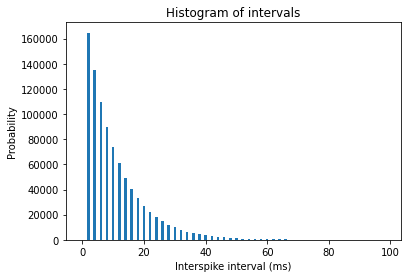

In [ ]:
class P1:
    __TL = s2ms(0.0)
    __TH = s2ms(10.0)
    __rate = 100.0
    __gen = Poisson_Generator(rate = __rate)
    def __init__(self):
        pass
    def __process(self):
        sq = self.__gen.output(low=self.__TL, high=self.__TH)
        sq.print()
        # print(sq.count_dis(assigned=10))
        plt.bar(np.arange(100, step=2), sq.count_dis(assigned=50))
        plt.xlabel('Interspike interval (ms)')
        plt.ylabel('Probability')
        plt.title('Histogram of intervals')
        # plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
        # plt.axis([40, 160, 0, 0.03])
        # plt.grid(True)
        plt.show()
    def __call__(self):
        self.__process()

W1 = P1()
W1()

# Problem 2

Add a refractory period to the Poisson spike generator by allowing the firing rate to depend on time. Initially, set the firing rate to a constant value, \\(r(t) = r_0\\). After every spike, set \\(r(t)\\) to \\(0\\), and then allow it to recover exponentially back to \\(r_0\\) with a time constant ref that controls the refractory recovery rate. In other words, have \\(r(t)\\) obey the equation

\\(\tau_\text{ref}\frac{\text{d}\ r}{\text{d}\ t}=r_0-r\\)

except immediately after a spike, when it is set to \\(0\\). Plot the coefficient of variation as a function of ref over the range \\(1\text{ms}\leq\tau_\text{ref}\leq 20 \text{ms}\\), and plot interspike interval histograms for a few different values of ref in this range. Compute the Fano factor for spike counts obtained over counting intervals ranging from \\(1\\) to \\(100 \text{ms}\\) for the case \\(\tau_\text{ref}=10\text{ms}\\).

Figuring the differential equation, wee have the expression of \\(r\\)

\\(r(t)=r_0(1-e^{-\frac{t}{\tau_\text{ref}}})\\)


SpikeS: 

	low: 0.0 high:  9999.998 
events:  [0. 0. 0. ... 0. 0. 0.]


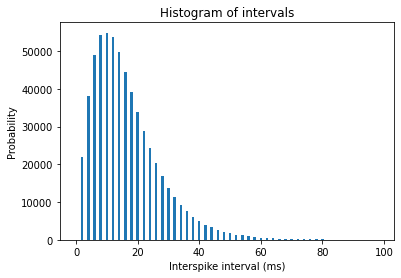

In [ ]:

class P2:
    __TL = s2ms(0.0)
    __TH = s2ms(10.0)
    __rate = 100.0
    __gen = Refractory_Generator(rate=__rate, rmap=Refractory_Func(r0=__rate, ref_period=0.01))
    __total_steps = 50
    def __init__(self):
        pass
    def __process(self):
        sq = self.__gen.output(low=self.__TL, high=self.__TH)
        sq.print()
        plt.bar(np.arange(self.__total_steps*2, step=2), sq.count_dis(assigned=self.__total_steps))
        plt.xlabel('Interspike interval (ms)')
        plt.ylabel('Probability')
        plt.title('Histogram of intervals')
        plt.show()
    def __call__(self):
        self.__process()

W2 = P2()
W2()

# Problem 3

Compute autocorrelation histograms of spike trains generated by a Poisson generator with a constant firing rate of \\(100 \text{Hz}\\), a constant firing rate of \\(100\\) Hz together with a refractory period modeled as in exercise 2 with \\(\tau_\text{ref}=10\text{ms}\\), and a variable firing rate \\(r(t) = 100(1 + \cos(2\pi t/25 \text{ms}))\text{Hz}\\). Plot the histograms over a range from \\(0\\) to \\(100\text{ms}\\).


epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9


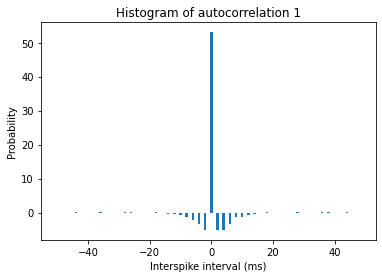

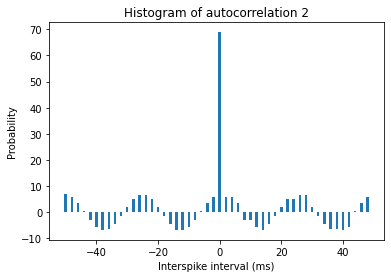

In [ ]:

class COSF(Func):
    def __init__(self, *args, **kwargs):
        super().__init__()
    def value(self, x:float=0.0, *args, **kwargs):
        return 100*(1+cos(2*pi*x/25 * 1000))

class P3:
    __TL = s2ms(0.0)
    __TH = s2ms(10.0)
    __rate1 = 100.0
    __rate2 = 200.0
    __gen1 = Refractory_Generator( rate=__rate1, rmap=Refractory_Func(r0=__rate1, ref_period=0.01) )
    __gen2 = Poisson_Generator( rate=__rate2, rmap=COSF() )
    __total_steps = 50
    __total_trials = 10
    def __init__(self):
        pass
    def __process(self):
        # print('---- step 1 ----')
        self.__gen1.reset( rate=self.__rate1, rmap=Refractory_Func(r0=self.__rate1, ref_period=0.01) )
        self.__gen2.reset( rate=self.__rate2, rmap=COSF() )
        # print('---- step 2 ----')
        sq1 = self.__gen1.output(low=self.__TL, high=self.__TH)
        sq2 = self.__gen2.output(low=self.__TL, high=self.__TH)
        # print('---- step 3 ----')
        auto_co1 = np.zeros(self.__total_steps)
        auto_co2 = np.zeros(self.__total_steps)
        if CST.GPU():
            auto_co1 = cp.asarray(auto_c1)
            auto_co2 = cp.asarray(auto_c2)
        # print('---- step 4 ----')
        for dist in np.arange(self.__total_steps*CST.delta(), step=CST.delta()):
            auto_co1[pos(dist)] = correlation(sq1.pure(), sq1.pure(), dist - self.__total_steps*CST.delta()/2)
            auto_co2[pos(dist)] = correlation(sq2.pure(), sq2.pure(), dist - self.__total_steps*CST.delta()/2)
        # print('---- step 5 ----')
        return (auto_co1, auto_co2)
    def __plot(self, number, sq):
        if CST.GPU():
            if isinstance(sq, cp.ndarray):
                sq = cp.asnumpy(sq)
        # print('k1: ', np.arange(-self.__total_steps*s2ms(CST.delta())/2, self.__total_steps*s2ms(CST.delta())/2, step=s2ms(CST.delta())))
        # print('k2: ', np.arange(self.__total_steps*s2ms(CST.delta()), step=s2ms(CST.delta())))
        plt.bar( np.arange(-self.__total_steps*s2ms(CST.delta())/2, self.__total_steps*s2ms(CST.delta())/2, step=s2ms(CST.delta()) ), sq[0:self.__total_steps])
        plt.xlabel('Interspike interval (ms)')
        plt.ylabel('Probability')
        plt.title('Histogram of autocorrelation %d' % number)
        plt.show()
    def __call__(self):
        sq1 = np.zeros(self.__total_steps)
        sq2 = np.zeros(self.__total_steps)
        if CST.GPU():
            sq1 = cp.asarray(sq1)
            sq2 = cp.asarray(sq2)
        for iter in range(self.__total_trials):
            print('epoch: ', iter)
            (t1, t2) = self.__process()
            if CST.GPU():
                sq1 = cp.add(sq1, t1)
                sq2 = cp.add(sq2, t2)
            else:
                sq1 = np.add(sq1, t1)
                sq2 = np.add(sq2, t2)
        sq1 = sq1 / self.__total_trials
        sq2 = sq2 / self.__total_trials
        self.__plot(1, sq1)
        self.__plot(2, sq2)

W3 = P3()
W3()

# Problem 4

Generate a Poisson spike train with a time-dependent firing rate \\(r(t)=100(1+\cos(2\pi t/300 ms))\text{Hz}\\). Approximate the firing rate from this spike train using a variable \\(r_\text{approx}\\) that satisfies

\\(\tau_\text{approx}\frac{d\ r_\text{approx}}{d\ t} =  -r_\text{approx}\\)

except that \\(r_\text{approx}\rightarrow r_\text{approx}+1/\tau_\text{approx}\\) every time a spike occurs. Make plots of the true rate, the spike sequence generated, and the estimated rate. Experiment with a few di erent values of approx in the range of \\(1\\) to \\(100\\) ms. Determine the best value R of approx by computing the average squared error of the estimate, \\(\int dt\ (r(t)-r_\text{approx}(t))^2\\), for different values of \\(\tau_\text{approx}\\) , and finding the value of \\(\tau_\text{approx}\\) that minimizes this error.

Solving the differential equation, we have

\\(r_\text{approx}=\exp(-\frac{t}{\tau_\text{approx}})\\)

However, I don't really get the author's intention, so this problem is left here.


In [ ]:

class FR_P4(Func):
    def __init__(self, ref_period:float=1.0, *args, **kwargs):
        self.__r0 = r0
        self.__ref_period = ref_period
    def value(self, x:float=0.0, *args, **kwargs):
        try:
            return exp(- x / self.__ref_period)
        except:
            print('x: ', x)

 # Problem 5

For a constant rate Poisson process, every specific (up to a finite resolution) sequence of \\(N\\) spikes occurring over a given time interval is equally likely. This seems paradoxical because we certainly do not expect to see all \\(N\\) spikes appearing within the first \\(1\%\\) of the time interval. Resolve this paradox.

\\(P_{1\%T}(N)=\frac{\exp(-\frac{rT}{100})(\frac{rT}{100})^{N}}{N!}\\)

\\(P_{T}(N)=\frac{\exp(-{rT})(rT)^{N}}{N!}\\)

\\(\frac{P_{1\%T}}{P_T}=\frac{\exp(-rT/100)}{100^N\exp(-rT)}\\)


# Problem 6

Build an approximate white-noise stimulus by choosing random values at discrete times separated by a time-step interval \\(\Delta t\\). Plot its autocorrelation function and power spectrum (use the matlab function spe trum or psd). Discuss how well this stimulus matches an ideal white-noise stimulus given the value of \\(\Delta t\\) you used.


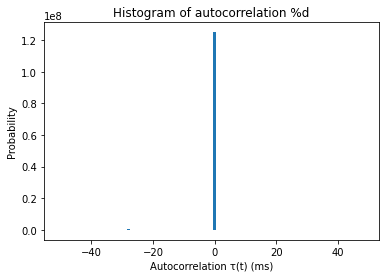

In [51]:
class Normal_Generator(Generator):
    def __init__(self, dtype:str='normal', mean:float=0.0, deviation:float=1.0, *args, **kwargs):
        super().__init__(dtype)
        self.__mean=mean
        self.__deviation=deviation
    def value(self, *args, **kwargs):
        # print(self.__mean, self.__deviation, args)
        return np.random.normal(self.__mean, self.__deviation, args)
    def output(self, low:float=0.0, high:float=1.0, *args, **kwargs):
        s = np.random.normal(self.__mean, self.__deviation, pos(high-low))
        ret = SpikeS(low, high, s)
        return ret

class P6:
    __TL = s2ms(0.0)
    __TH = s2ms(10.0)
    __deviation = 1.0
    __total_steps = 50
    __gen = Normal_Generator(mean=0.0, deviation=__deviation/CST.delta())
    def __init__(self, *args, **kwargs):
        pass
    def __process(self, *args, **kwargs):
        sq = self.__gen.output(self.__TL, self.__TH)
        ret = np.zeros(self.__total_steps)
        for dist in np.arange(self.__total_steps*CST.delta(), step=CST.delta()):
            ret[pos(dist)] = correlation(sq, sq, dist - self.__total_steps*CST.delta()/2)
        return ret
    def __plot(self, sq, *args, **kwargs):
        if CST.GPU():
            if isinstance(sq, cp.ndarray):
                sq = cp.asnumpy(sq)
        plt.bar( np.arange(-self.__total_steps*s2ms(CST.delta())/2, self.__total_steps*s2ms(CST.delta())/2, step=s2ms(CST.delta()) ), sq[0:self.__total_steps])
        plt.xlabel('Autocorrelation \u03C4(t) (ms)')
        plt.ylabel('Probability')
        plt.title('Histogram of autocorrelation %d')
        plt.show()
    def __call__(self, *args, **kwargs):
        sq = self.__process()
        self.__plot(sq)

W6 = P6()
W6()

# Problem 7

Consider a model with a firing rate determined in terms of a stimulus \\(s(t)\\) by integrating the equation

\\(\tau_{r}\frac{dr_\text{est}(t)}{dt}=[r_0+s]_+-r_\text{est}(t)\\)

where \\(r_0\\) is a constant that determines the background firing rate and
\\(r=20\text{ms}\\). Drive the model with an approximate white-noise stimulus. Adjust the amplitude of the white-noise and the parameter \\(r_0\\) so that rectification is not a big e ect (i.e. \\(r_0+s>0\\) most of the time). From the responses of the model, compute the stimulus-response correlation function, \\(Q_{rs}\\) . Next, generate spikes from this model using a Poisson generator with a rate \\(r_\text{est}(t)\\), and compute the spike-triggered average stimulus from the spike trains produced by the white-noise stimulus. By comparing the stimulus-response correlation function with the spike-triggered average, verify that equation 1.22 is satisfied. Examine what happens if you set \\(r_0=0\\), so that the white-noise stimulus becomes half-wave rectified.

Solving the differential equation, we have

\\(r_\text{est}(t)=r_0(1-e^{-t/\tau_r})\\)

The coding part is trivial, and similar to previous problems, so we omit it.


# Problem 8

matlab® file c1p8.mat contains data collected and provided by Robde Ruyter van Steveninck from a fly H1 neuron responding to an approximate white-noise visual motion stimulus. Data were collected for \\(20\\) minutes at a sampling rate of \\(500\text{Hz}\\). In the file, rho is a vector that gives the sequence of spiking events or nonevents at the sampled times (every \\(2\text{ms}\\)). When an element of rho is one, this indicates the presence of a spike at the corresponding time, whereas a zero value indicates no spike. The variable stim gives the sequence of stimulus values at the sampled times. Calculate and plot the spike-triggered average from these data over the range from \\(0\\) to \\(300\text{ms}\\) (\\(150\\) time steps). (Based on a problem from Sebastian Seung.)


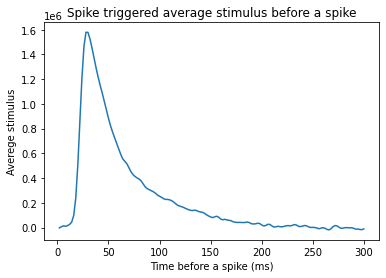

In [80]:
class P8:
    def __init__(self, file_name:str='c1p8.mat', *args, **kwargs):
        mat = scipy.io.loadmat(file_name=file_name)
        self.__response = mat['rho'].squeeze()
        self.__stimuli = mat['stim'].squeeze()
        self.__TH = 20*60.0
        self.__TL = 0.0
        self.__total_steps = 150
    def __process(self, *args, **kwargs):
        # self.__stimuli = SpikeS(self.__TL, self.__TH, self.__stimuli)
        # self.__response = SpikeS(self.__TL, self.__TH, self.__response)
        ret = np.zeros(self.__total_steps)
        for (index, value) in enumerate(self.__response):
            if value == 1:
                if index >= self.__total_steps:
                    ret = np.add( ret, self.__stimuli[index-1 : index-self.__total_steps-1 : -1] )
                else:
                    # print(index, self.__total_steps-index, (self.__stimuli[0:index]))
                    ret = np.add( ret, np.concatenate( (np.flip(self.__stimuli[0:index]), np.zeros(self.__total_steps-index)) ) )
        return ret
    def __plot(self, sq, *args, **kwargs):
        plt.plot(np.arange(300, 0, -2), np.flip(sq))
        plt.xlabel('Time before a spike (ms)')
        plt.ylabel('Averege stimulus')
        plt.title('Spike triggered average stimulus before a spike')
        plt.show()
    def __call__(self, *args, **kwargs):
        sq = self.__process()
        self.__plot(sq)

W8 = P8()
W8()

# Problem 9

Using the data of problem 8, calculate and plot stimulus averages triggered on events consisting of a pair of spikes (which need not necessarily be adjacent) separated by a given interval (as in figure 1.10).
Plot these two-spike-triggered average stimuli for various separation intervals ranging from \\(2\\) to \\(100\text{ms}\\). (Hint: in matlab® , use convolution for pattern matching: e.g. find(conv(rho,[1 \\(\emptyset\\) 1]==2) will contain the indices of all the events with two spikes separated by \\(4\text{ms}\\).) Plot, as a function of the separation between the two spikes, the magnitude of the di erence between the two-spike-triggered average and the sum of two single-spike-triggered averages (obtained in exercise 8) separated by the same time interval. At what temporal separation does this di erence become negligibly small. (Based on a problem from Sebastian Seung.)

The coding is trivial, we omit it.



# Problem 10

Using the data of problem 8, find the spike-triggered average stimulus for events that contain exactly two adjacent spikes separated by various di erent intervals ranging from 2 to 100 ms (e.g. for 4 ms, the event [1 0 1℄ but not the event [1 1 1℄). This is distinct from exercise 9 in which we only required two spikes separated by a given interval, but did not restrict what happened between the two spikes. Compare results of the exclusive case considered here with those of the inclusive two-spike-triggered average computed in exercise 9. In what ways and why are they di erent? (Based on a problem from Sebastian Seung.)

The coding is also, trivial, we omit it.